In [1]:
# basic libraries import
import os
import glob
import sys
import pandas as pd
import numpy as np

#reading data
import json

# Plotting libraries and parameters
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rc('figure', figsize = (20, 8))
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', facecolor = 'white')
matplotlib.rc('axes', grid = False)
matplotlib.rc('font', size = 14)





In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Which Size Fits Me/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Which Size Fits Me


In [3]:
pwd

'/gdrive/My Drive/Which Size Fits Me'

In [4]:
BASE_PATH = "./Data/"
BASE_MODEL_PATH = "./Model/"

In [5]:
all_filenames = []
for filename in glob.iglob(os.path.join(BASE_PATH, "*.json"), recursive = True):
  all_filenames.append(filename)

In [6]:
modcloth_df = pd.read_json(all_filenames[0], lines = True) #by above data reading technique,
# we were not able to identify right attribute type for the columns


In [7]:
# Changing column names and removing unecessary spaces
modcloth_df.columns = [x.replace(" ","_") for x in modcloth_df.columns]

In [8]:
# There are some columns that can be converted to numeric datatype but are not 
# due to some inconsistencies
modcloth_df["bust"].unique() #presence of 37-39
modcloth_df["height"].unique() # can be converted to cms
modcloth_df.length.unique() #these are textual in nature
modcloth_df.shoe_width.unique() ##these are textual in nature

array([nan, 'wide', 'average', 'narrow'], dtype=object)

In [9]:
def normalize_bust_values(x):
  """ Function to normalize the bust values"""
  try:
    if pd.notnull(x):
      if "-" in x:
        assert len(x.split("-")) == 2
        return np.mean([int(num) for num in x.split("-")])
      else:
        return int(x) #Can throw an exception
  except Exception as e: 
    # For anykind of exception return None
    return None
  return None
  
def normalize_height_values(x):
  """ Function to normalize the height values"""
  if pd.notnull(x):
    try: 
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    except:
        return (int(x[0])*30.48) # there can't be a 10ft+ customer,neither was observed
  return None

In [10]:

modcloth_df["bust"] = modcloth_df["bust"].apply(lambda x: normalize_bust_values(x))
modcloth_df["height"] = modcloth_df["height"].apply(lambda x: normalize_height_values(x))

In [11]:

# Removing inconsistencies in numerical data
modcloth_df.describe()

,item_id,waist,size,quality,hips,bra_size,bust,height,user_id,shoe_size
count,82790.000000,2882.000000,82790.000000,82722.000000,56064.000000,76772.000000,11854.000000,81683.000000,82790.000000,27915.000000
mean,469325.229170,31.319223,12.661602,3.949058,40.358501,35.972125,37.499241,165.471906,498849.564718,8.145818
std,213999.803314,5.302849,8.271952,0.992783,5.827166,3.224907,4.635117,7.245308,286356.969459,1.336109
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,20.000000,91.440000,6.000000,5.000000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,34.000000,160.020000,252897.750000,7.000000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,36.000000,165.100000,497913.500000,8.000000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,40.000000,170.180000,744745.250000,9.000000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,59.000000,241.300000,999972.000000,38.000000


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


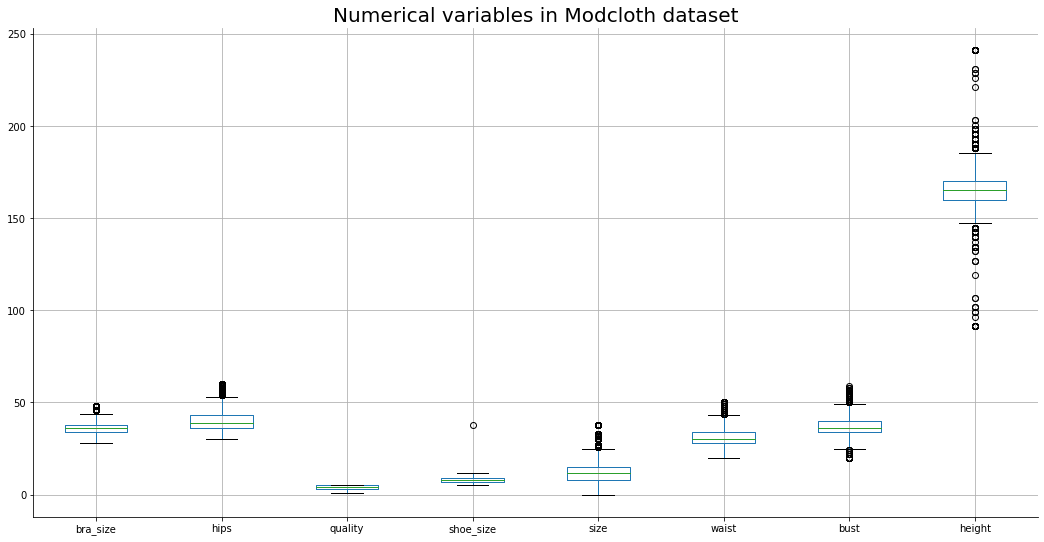

In [12]:
num_cols = ['bra_size','hips','quality','shoe_size','size','waist', 'bust', 'height', ]
plt.figure(figsize=(18,9))
modcloth_df[num_cols].boxplot()
plt.title("Numerical variables in Modcloth dataset", fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


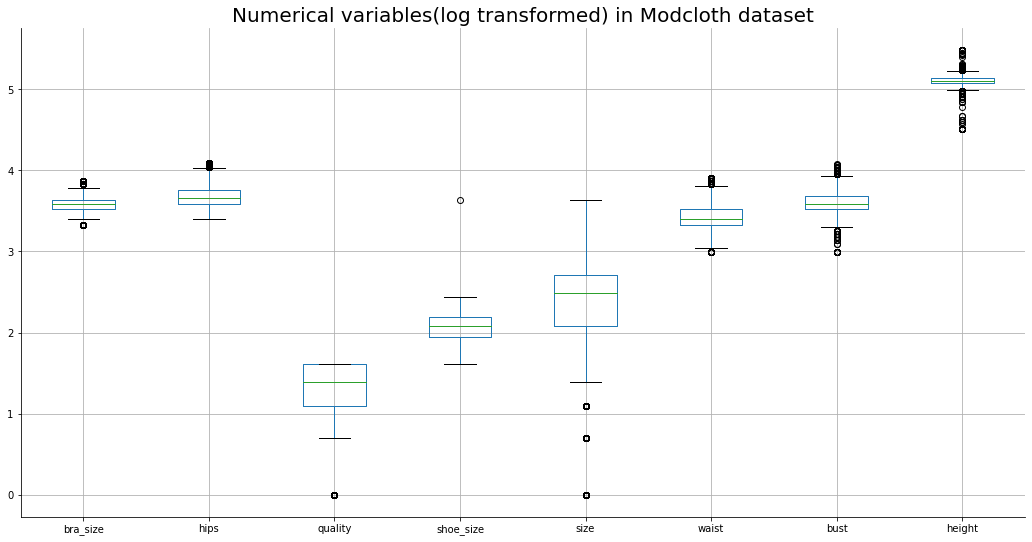

In [13]:
num_cols = ['bra_size','hips','quality','shoe_size','size','waist', 'bust', 'height', ]
plt.figure(figsize=(18,9))
np.log(modcloth_df[num_cols]).boxplot()
plt.title("Numerical variables(log transformed) in Modcloth dataset", fontsize=20)
plt.show()

In [14]:
Q1 = modcloth_df.quantile(0.25)
Q3 = modcloth_df.quantile(0.75)
Q1.drop(["item_id","user_id"], inplace =True)
Q3.drop(["item_id","user_id"], inplace = True)
IQR = Q3 - Q1

In [15]:
modcloth_df = modcloth_df[~((modcloth_df < (Q1 - 1.5 * IQR)) |(modcloth_df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [16]:
modcloth_df.reset_index(drop=True, inplace=True)


In [17]:

# Checking amount of missing values
missing_data = pd.DataFrame({'perc_missing': (modcloth_df.isnull().sum()/modcloth_df.shape[0])*100})
missing_data.sort_values("perc_missing", ascending=False, inplace = True)
missing_data

,perc_missing
waist,96.371036
bust,85.001403
shoe_width,77.200393
shoe_size,65.216110
hips,31.618019
review_text,8.005894
review_summary,8.005894
cup_size,7.325288
bra_size,6.994106
height,1.211058


In [18]:
# The first 4 columns namely waist, bust, shoe_width and shoe_size have high number of mising data
# and hence should be dropped. shoe_size can be indicators for product to be a shoe
# otherwise they should be dropped as well


# Checking of product is a shoe 
shoe_review_df = modcloth_df[np.logical_and(pd.notnull(modcloth_df["review_text"]), pd.notnull(modcloth_df["shoe_size"]))][["user_name","shoe_size","review_text"]]

In [19]:
shoe_review_df.shape


(22958, 3)

In [20]:
# %age review containing shoe mentions
import re
np.sum([True if len(re.findall(r"shoes|shoe",x))> 0 else False for x in shoe_review_df.review_text])/shoe_review_df.shape[0]

0.003745970903388797

In [21]:
# There are 585 users with differing shoe_sizes (since time information is not present,
 # also the person for which the product is bought for is not known) it is difficult
 # to call this misrepresentation as an error
np.sum(shoe_review_df.groupby('user_name')['shoe_size'].unique().apply(lambda x: len(x)) > 1)

585

In [22]:
# There are roughly 700 new additions to the above logic, which means that for the same
# user the shoe_size is reported but is not reproted somewhere else in the data.
np.sum(modcloth_df.groupby('user_name')['shoe_size'].unique().apply(lambda x: len(x)) > 1)

1201

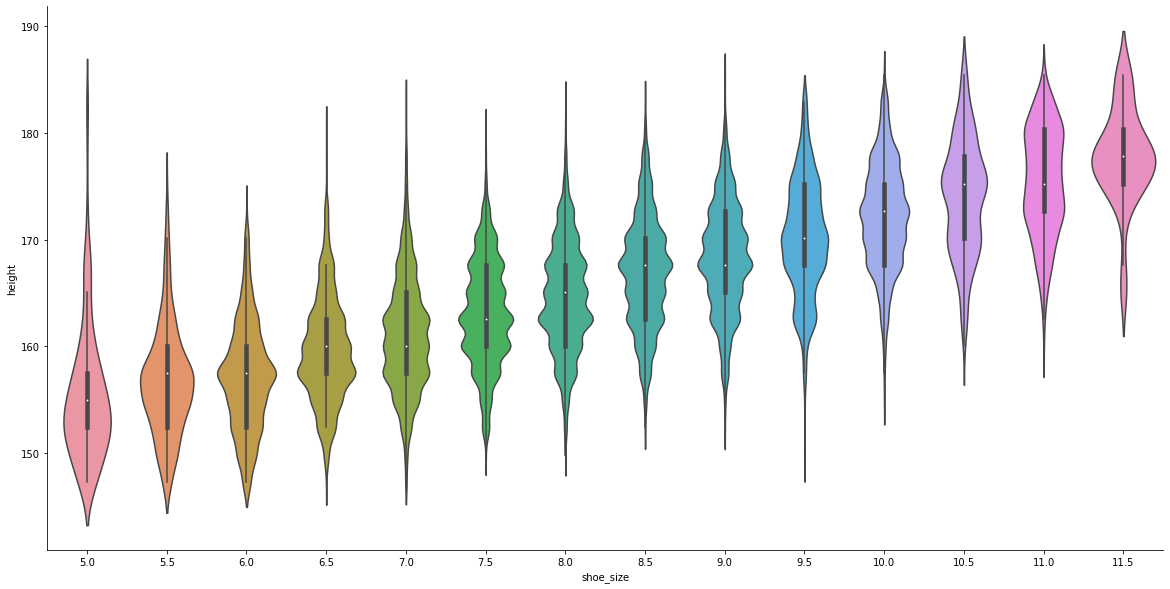

In [23]:
fig = plt.gcf()
fig.set_size_inches(20,10)
__ = sns.violinplot(x='shoe_size', y='height',data=modcloth_df)

In [24]:
modcloth_df.drop(["waist", "bust", "shoe_width", "shoe_size"], axis= 1, inplace=True)


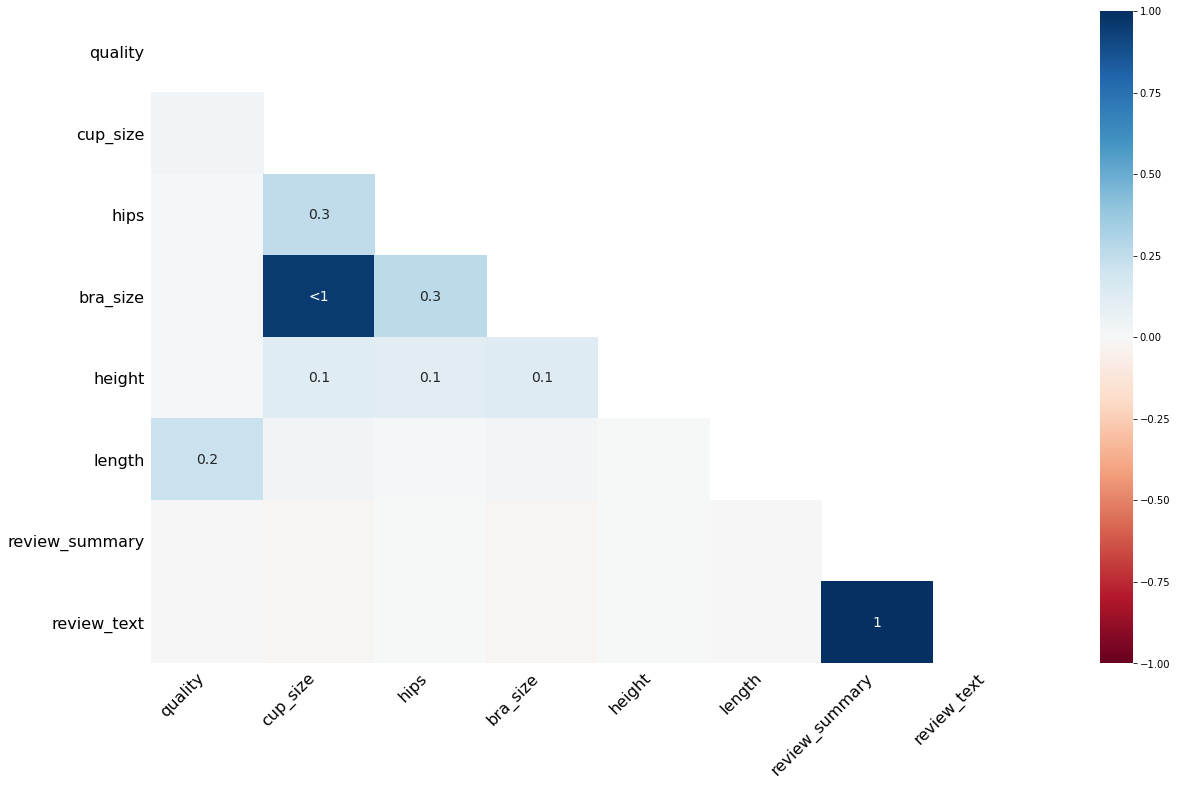

In [25]:
# missing values in different columns as a heatmap
import missingno as msno

msno.heatmap(modcloth_df)

In [26]:
bra_size_to_cup_size = {x:y for x,y in modcloth_df.groupby("bra_size")["cup_size"].agg(pd.Series.mode).reset_index().values}
cup_size_to_bra_size = {x:y for x,y in modcloth_df.groupby("cup_size")["bra_size"].median().reset_index().values}

bra_size_med = modcloth_df.bra_size.median() 
cup_size_mod = bra_size_to_cup_size[bra_size_med] # not matching with cup size mode

In [27]:
imputed_value = []
for x,y in zip(modcloth_df["bra_size"],modcloth_df["cup_size"]):
  if pd.isnull(x) and pd.isnull(y):
    imputed_value.append([bra_size_med, cup_size_mod])
  elif pd.isnull(x) and pd.notnull(y):
    imputed_value.append([cup_size_to_bra_size[y], y])
  elif pd.notnull(x) and pd.isnull(y):
    imputed_value.append([x, bra_size_to_cup_size[x]])
  else:
    imputed_value.append([x,y])

In [28]:
modcloth_df[["bra_size","cup_size"]] = imputed_value


In [29]:
modcloth_df.review_summary.fillna("Unknown", inplace=True)
modcloth_df.review_text.fillna("Unknown", inplace=True)


In [30]:
!pip install scikit-learn==0.21

In [31]:
from sklearn.preprocessing import Imputer
median_imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
modcloth_df[['height','quality']] = median_imputer.fit_transform(modcloth_df[['height','quality']])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


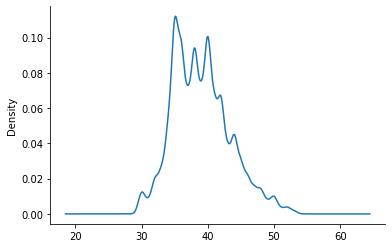

In [32]:
modcloth_df["length"] = modcloth_df.length.fillna(modcloth_df['length'].value_counts().index[0])
modcloth_df.hips.plot.kde()


In [33]:
modcloth_df.hips.fillna(-1.0, inplace = True)
bins = [-2,0,31,37,40,44,75]
labels = ['Unknown','XS','S','M', 'L','XL']
modcloth_df.hips = pd.cut(modcloth_df.hips, bins, labels=labels)

In [34]:
modcloth_df.drop('review_summary', axis=1, inplace = True)


In [35]:
name_id_df = modcloth_df.groupby("user_name")['user_id'].apply(lambda x: len(np.unique(x))).reset_index()
id_name_df = modcloth_df.groupby("user_id")['user_name'].apply(lambda x: len(np.unique(x))).reset_index()

In [36]:
modcloth_df.drop('user_id', axis=1, inplace = True)
modcloth_df["user_name"] = modcloth_df.user_name.apply(lambda x: x.lower())

In [37]:
modcloth_df.shape

(71260, 12)

In [38]:
type(modcloth_df)

pandas.core.frame.DataFrame

In [39]:
modcloth_df.to_csv(BASE_PATH+"/processed_data.csv")

In [40]:
pip install pipreqs


In [43]:
import pipdeptree


In [51]:
pipdeptree --json-tree

TypeError: ignored